In [50]:
from transformers import AutoTokenizer

ModuleNotFoundError: No module named 'transformers'

# saturi 프로젝트 EDA

In [1]:
# analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import tqdm

# other
import os

In [2]:
data_path = os.getenv('HOME') + '/aiffel/DATA'

## Load Data

In [3]:
df_train = pd.read_pickle(data_path + '/data_train_spm_4000_0317.pkl','gzip')
df_test = pd.read_pickle(data_path + '/data_test_spm_4000_0317.pkl','gzip')
df_test['weight'] = df_test['tok_cat'].apply(lambda x : 14 - x)
df_test = df_test.loc[df_test['tok_cat'] < 6].sample(n=250, weights = 'weight' ,random_state=6) # validation 시간이 너무 오래 걸림, 250개만 사용

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340262 entries, 0 to 1340261
Data columns (total 8 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   reg       1340262 non-null  object
 1   topic     1340262 non-null  object
 2   eng       1340262 non-null  object
 3   dial      1340262 non-null  object
 4   tok_len   1340262 non-null  int64 
 5   tok_cat   1340262 non-null  int64 
 6   toks_en   1340262 non-null  object
 7   toks_dec  1340262 non-null  object
dtypes: int64(2), object(6)
memory usage: 81.8+ MB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 1362 to 893
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   reg       250 non-null    object
 1   topic     250 non-null    object
 2   eng       250 non-null    object
 3   dial      250 non-null    object
 4   tok_len   250 non-null    int64 
 5   tok_cat   250 non-null    int64 
 6   toks_en   250 non-null    object
 7   toks_dec  250 non-null    object
 8   weight    250 non-null    int64 
dtypes: int64(3), object(6)
memory usage: 19.5+ KB


In [6]:
# check duplicates
print('train duplicated count :' ,df_train.duplicated(subset='dial').sum())
print('test duplicated count :' ,df_test.duplicated(subset='dial').sum())

train duplicated count : 0
test duplicated count : 0


In [7]:
# check for any overlaps in train and test
tr_dial = df_train.dial.values
ts_dial = df_test.dial.values
temp_ = np.concatenate([tr_dial, ts_dial], axis=0)
temp_ = print('overlap count : ',pd.DataFrame(temp_).duplicated().sum())

overlap count :  0


### reg별 데이터 분포

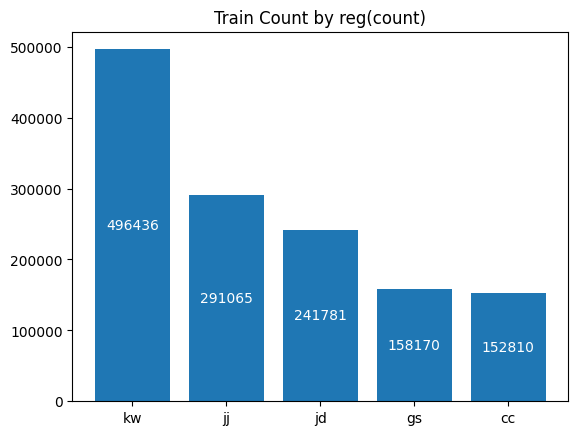

In [11]:
# count per region
data = df_train.reg.value_counts()
# data_ts = df_test.reg.value_counts(normalize=True).multiply(100).round(2)

fig, ax = plt.subplots()
p = ax.bar(data.index, data)
ax.bar_label(p, label_type='center', color='white')
plt.title("Train Count by reg(count)")
plt.show()

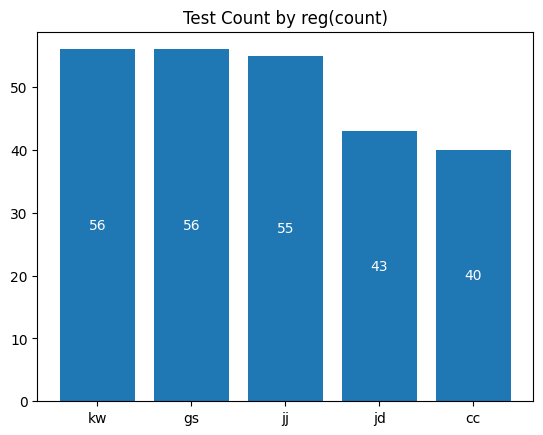

In [12]:
# count per region
data = df_test.reg.value_counts()
# data_ts = df_test.reg.value_counts(normalize=True).multiply(100).round(2)

fig, ax = plt.subplots()
p = ax.bar(data.index, data)
ax.bar_label(p, label_type='center', color='white')
plt.title("Test Count by reg(count)")
plt.show()

### topic별 분포

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [9]:
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
for i in font_list :
    fm.fontManager.addfont(i)
plt.rcParams['font.family'] = 'NanumBarunGothic'

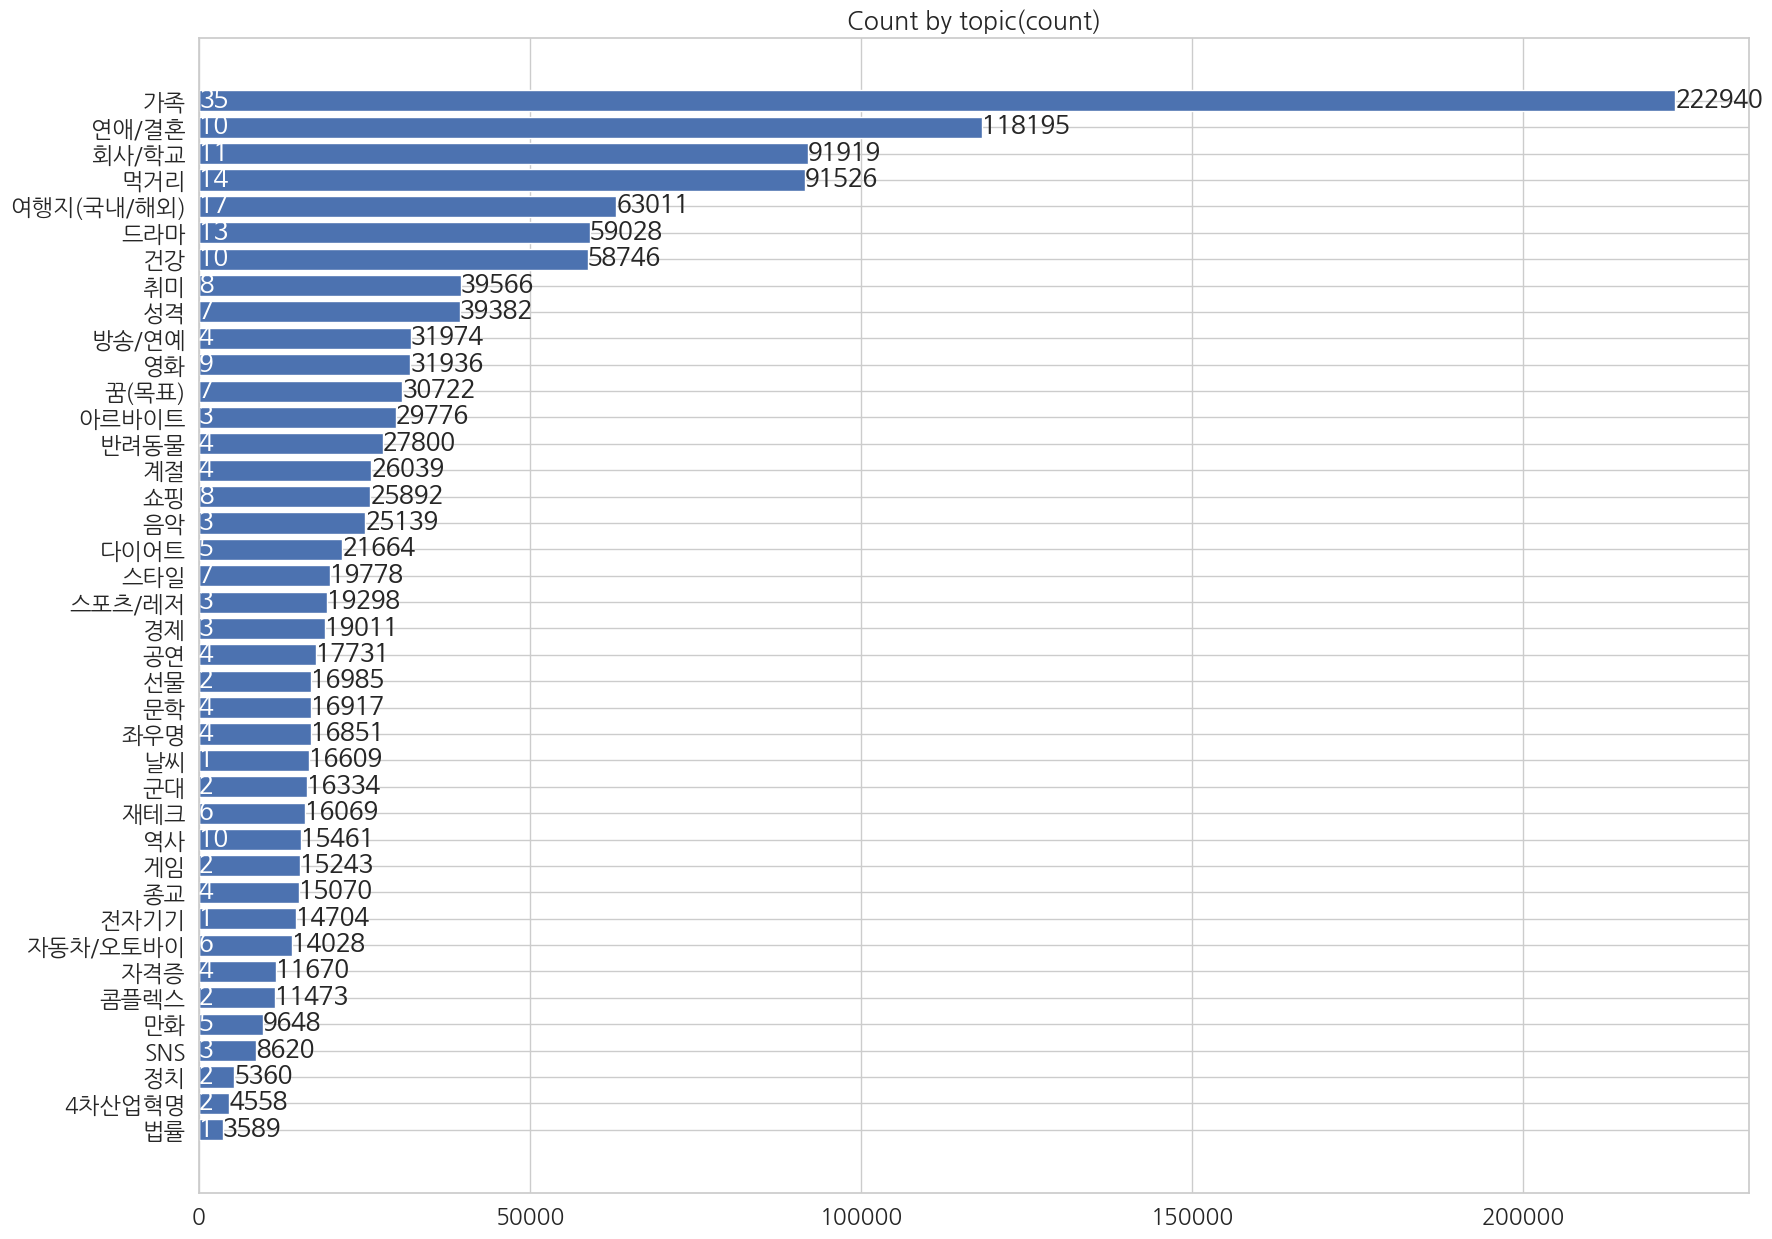

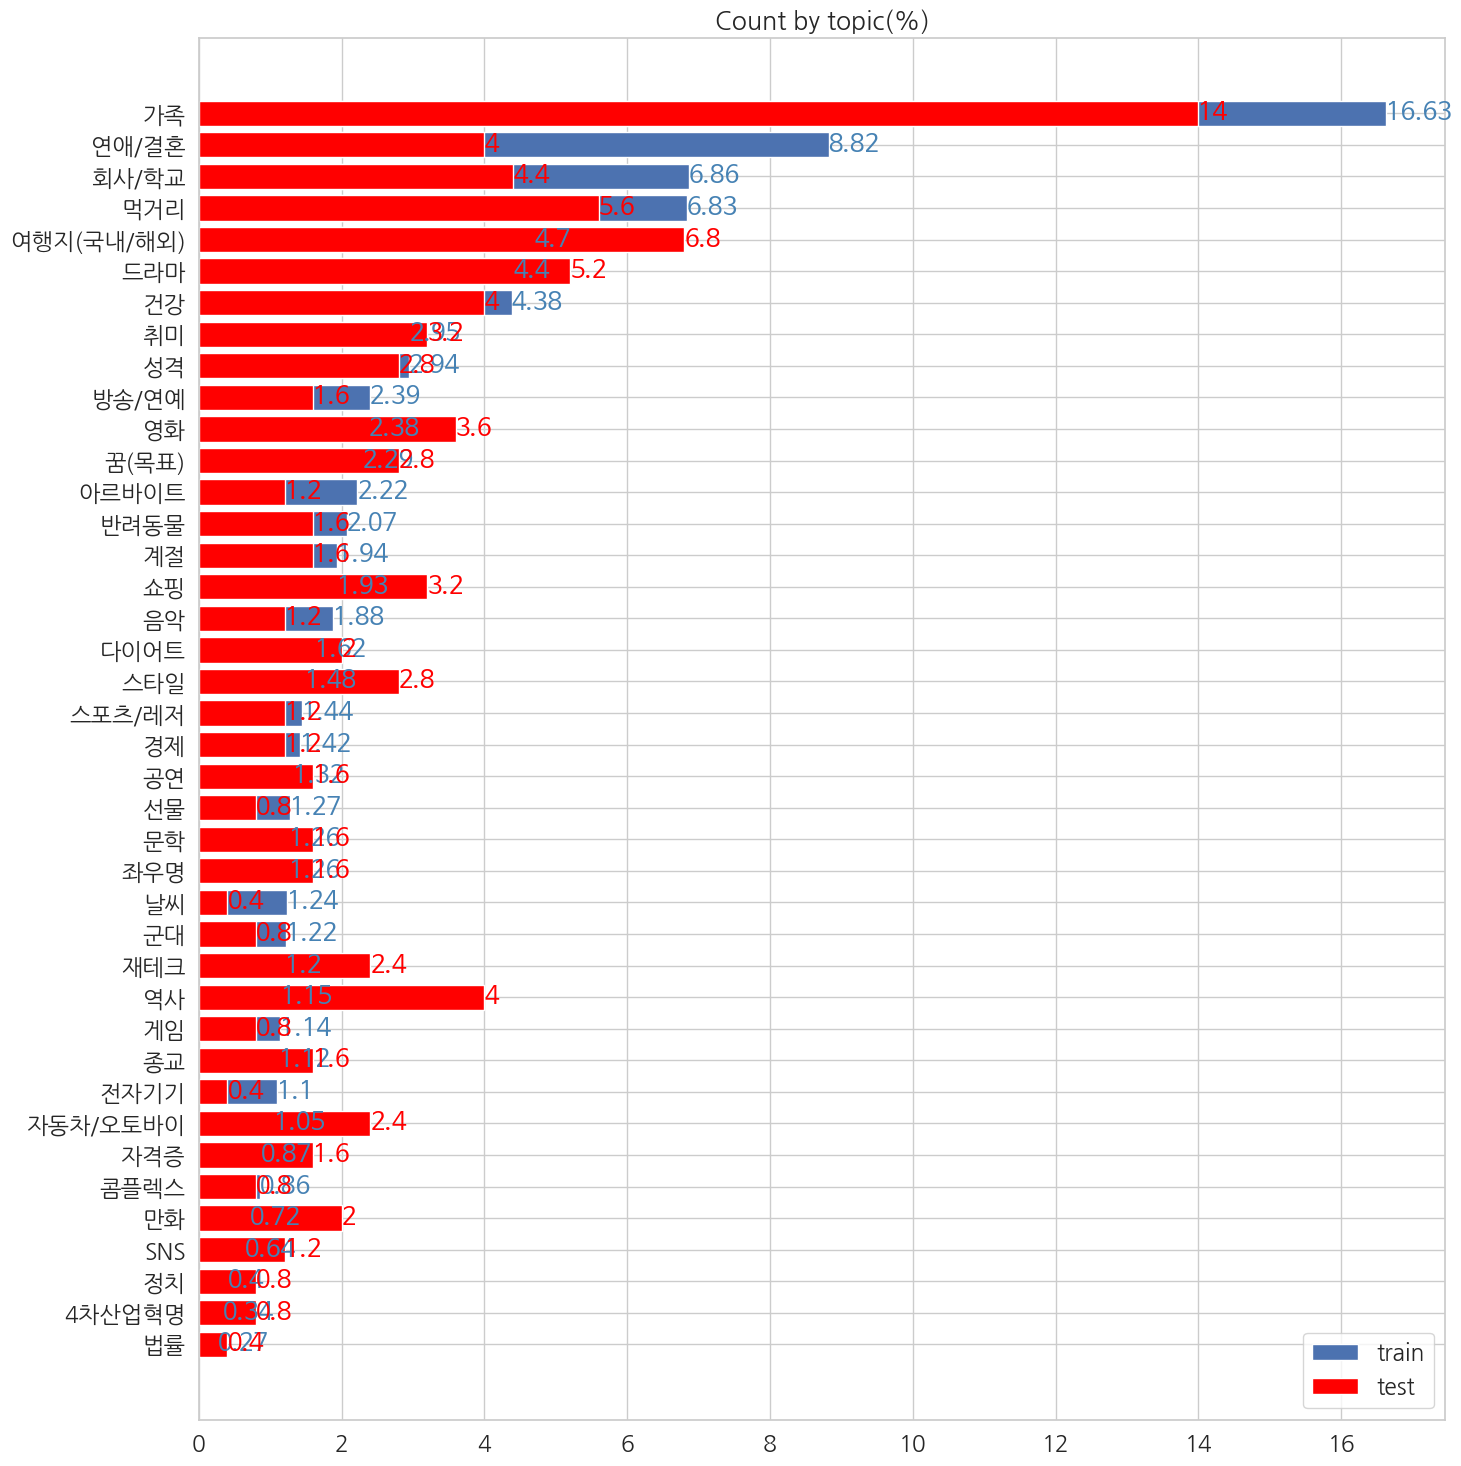

In [177]:
# check by topic
data = df_train.topic.value_counts().sort_values(ascending=True)
data_ts = df_test.topic.value_counts().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(20,15))
p = ax.barh(data.index, data, align='center')
t = ax.barh(data_ts.index, data_ts, align='center', color='red')
ax.bar_label(p, font='NanumBarunGothic')
ax.bar_label(t, color='white', font='NanumBarunGothic')
plt.title("Count by topic(count)")

data = df_train.topic.value_counts(normalize=True).multiply(100).round(2).sort_values(ascending=True)
data_ts = df_test.topic.value_counts(normalize=True).multiply(100).round(2).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(15,15))
p = ax.barh(data.index, data, align='center',label='train')
t = ax.barh(data_ts.index, data_ts, align='center', color='red', label='test')
ax.bar_label(p, color = 'steelblue',font='NanumBarunGothic')
ax.bar_label(t, color='red', font='NanumBarunGothic')
plt.legend()
plt.title("Count by topic(%)")

plt.tight_layout()
plt.show()

In [16]:
regs = df_train.reg.unique()

### Char & Seq length 

In [189]:
# check max, min, ave range in data

def sen_len(corpus, kor=False) :
    max_len = 0
    min_len = 999
    cum_len = 0
    max_content = ''
    min_content = ''
    for i in corpus :
        if kor : 
            i = i[0]
        length = len(i)
        if length >= max_len : 
            max_len = length
            max_content = i
        if length <= min_len : 
            min_len = length
            min_content = i
        cum_len += length
    
    print(f'max_len : {max_len}')
    print('max_content :', max_content)
    print(f'min_len : {min_len}')
    print('min_content :', min_content)
    print(f'average_len : {round(cum_len/len(corpus),1)}')
    
    return max_len, min_len, cum_len

def plot_seq_dist(corpus,kor=False) :
    max_len, min_len , _ = sen_len(corpus,kor)
    seq_len_matrix = np.zeros((max_len+1), dtype=int)
    for i in corpus :
        if kor :
            i = i[0]
        length = len(i)
        seq_len_matrix[length] += 1
    
    fig,ax = plt.subplots()
    hist = ax.bar(range(len(seq_len_matrix)),seq_len_matrix, color='steelblue', width=1)
    plt.title('char_len_distribution')
    plt.show()

max_len : 650
max_content : 근꼬 아 뭐~ 예 정도느 뭐~ 괘안아 내 뭐~ 예 정도까지느 내나 인생 수업한 꺼꼬 경제 수업한 끼라꼬 생각해.  증말 아깝대이 이른 꺼 쓸데없이 이른 꺼를 랑 하꼬 고런 생각 드는데 그기 예산이 또 느무 남아도 알았느 된대이 가주꼬 뭐~  지느 주로 구매하느 기 지가 쫌 화장품에 관심이 많아가 화장품이라던지를 아이머 바디용품을 쫌 마이 사느 편인디  그서 쫌 뭐~ 우짤 수 없은 상황이꼬 당연히 약깐 복지를 국가들을 따라가야 된다느 건 맞지마  컴퓨터에 쫌 관심이 많았었는데 고런 식으로 가격대를 또 부대이 보믄은 아 요거를 또 굳이 사야 되노 이른 식으로 생각을 마이 카느 꺼 같애예 이기 또 가격이나 금액대가 있으먼은  지느 쪼깨 약깐 즈그 남편도 부에 관련된 책을 자꼬 읽어보래이 얘기를 카거든예 니 관념을 쫌 바까야 된대이.  보믄 머 니가 좋아하느 그륵이라든둥 이른 디느 쫌 욕심을 부려서 그렇지를.  약깐 쫌 안타까운 꺼 긋해 주 꺼머 고로 주던가 아니믄은 주질 말든가  쫌 학원비가 쫌 비싸께 들어가예 짐  그리 꼬 옷을 먼저 사가 입어보느 데라가 똔을 또 그마이 또 투자를 칼 수 있대이 생각하거든.  부모님한테 더 돌라꼬 카꼬 고런 경우가 쫌 자주 있더라고예.  쓸 데 쫌 씨꼬 여러 간대이 고로 경험도 마이 카꼬 이른 데 똔을 마이 쓰시꼬 
min_len : 2
min_content : 도 
average_len : 64.3


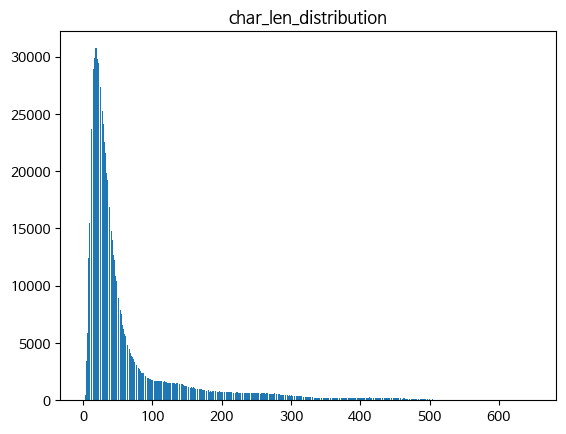

In [20]:
# train : dialect corpus by character
plot_seq_dist(df_train['dial'])

max_len : 1407
max_content : <cc> In the case of winter, you're gonna have to put something on the back of the table, and you're gonna have to put something on the back, and then you're gonna have to put something on the back of the table, and then you're gonna have to put something on the back of the table, and then you're gonna have to put something on the back, and then you're gonna have to put something on the back of the table, and then you're gonna have to put something on the back of the table, and then you're gonna have to put something on the floor, and then you're gonna have to put something on the floor, and then you're gonna have to put something on the floor, and then you're gonna have to do it. Have you thought about any other hobbies other than those? I want to learn yoga but theres no place to learn. I was a little busy during the semester so I couldnt do this until the last summer vacation I've been trying to read a lot of my own books, thinking that I'm going to have 

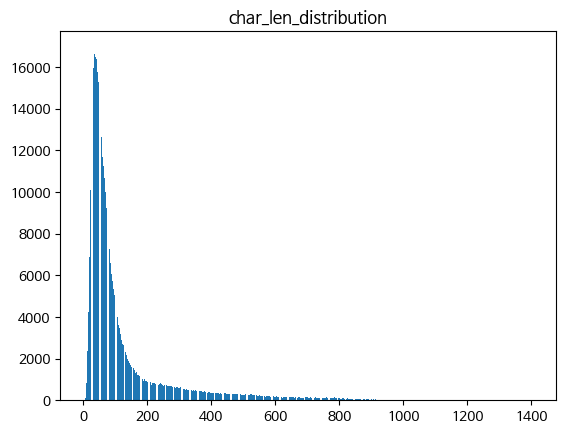

In [21]:
#english
plot_seq_dist(df_train['eng'])

In [22]:
df_train['c_len'] =df_train['dial'].apply(lambda x : len(x))

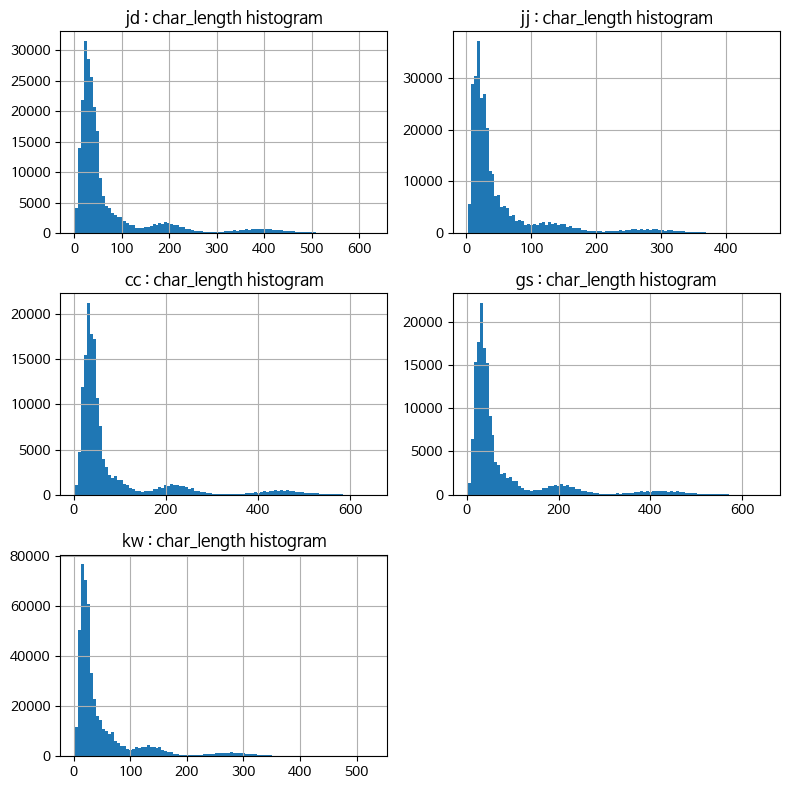

In [23]:
#by reg
plt.figure( figsize=(8,8))
for i, reg in enumerate(regs) :
    plt.subplot(3,2,i+1)
    ax = df_train.loc[df_train['reg'] == reg,'c_len'].hist(bins=100)
    plt.title(f'{reg} : char_length histogram')
plt.tight_layout()
plt.show()

max_len : 232
max_content : 올라갈 수 있도록 노력해 -봐야- 봐야 될 꺼 긋해 그자?  그서 막 순수한 느낌 이른 건 없었는데 미얀마 쫌 이케 터치가 들 됐느 느낌 사람들이?  그머 알았느 되느 기래이 알았제?  숙박이랑 막 고런 그느 아에 알았느 되거든예 정상 찍꼬 올래이 카머 인대이 아에 아침 일찍부터 가야 된대이 가주꼬  요번 초에 요번 연도 초에 갔대이 아가 일월에  회를 묵느 꺼를 추천한대이 그머 일단은 광안리를 쫌 추천을 카꼬 
min_len : 5
min_content : 그서 걍 
average_len : 66.2


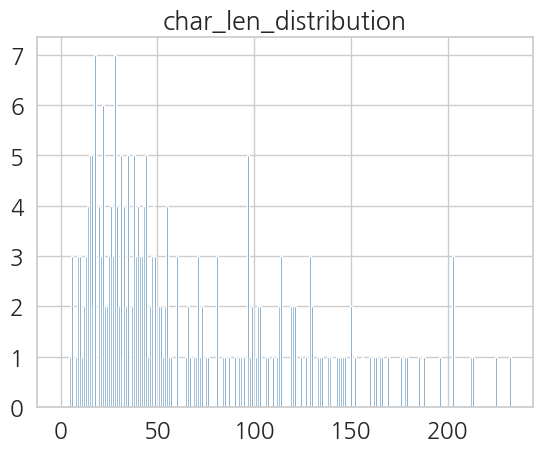

In [190]:
#test
plot_seq_dist(df_test['dial'])

max_len : 361
max_content : <cc> Imashing as Im still thinking that I wont fall Yes we came here and lost our wealth in many ways It's a fall, so if you had two billion dollars... So if you come to work on the weekend and eat and eat out what should you do Its just high in this house and have five or six machines in it. Daughter you just bought that like three hundred and five thousand.
min_len : 14
min_content : <kw> Try this.
average_len : 124.9


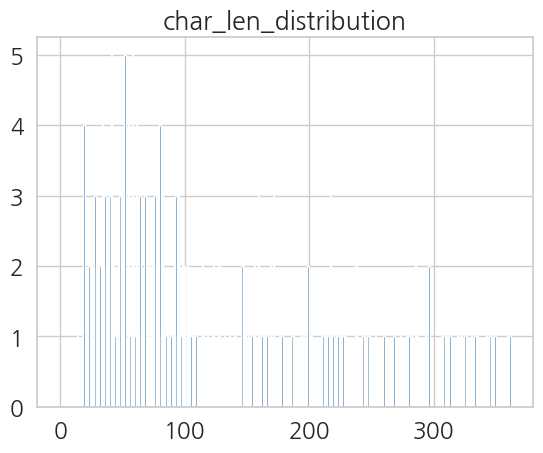

In [191]:
plot_seq_dist(df_test['eng'])

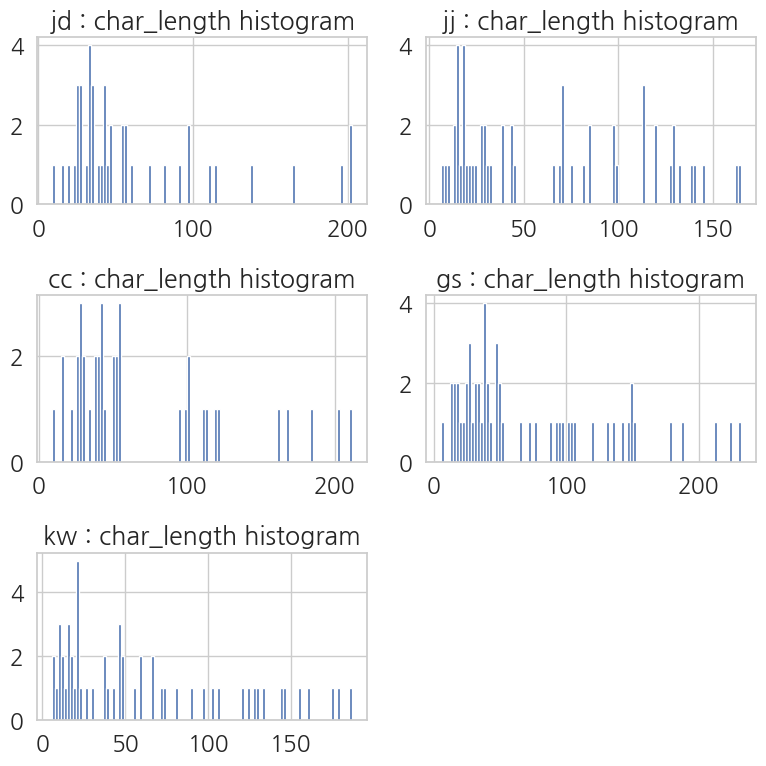

In [192]:
df_test['c_len'] =df_test['dial'].apply(lambda x : len(x))
#by reg
plt.figure( figsize=(8,8))
for i, reg in enumerate(regs) :
    plt.subplot(3,2,i+1)
    ax = df_test.loc[df_test['reg'] == reg,'c_len'].hist(bins=100)
    plt.title(f'{reg} : char_length histogram')
plt.tight_layout()
plt.show()

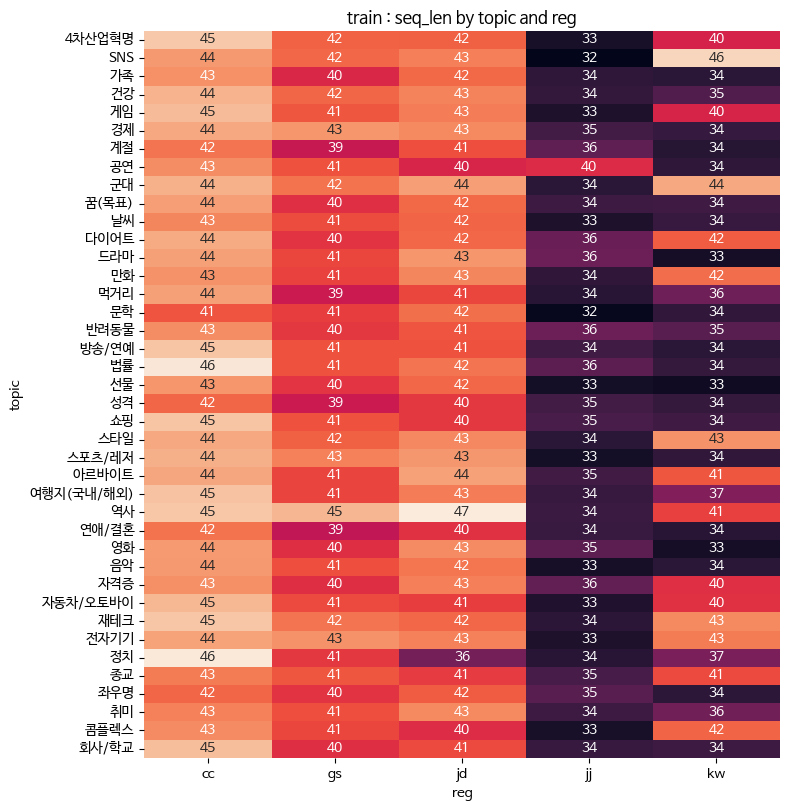

In [27]:
# reg, topic, tok_len 평균

import seaborn as sns
plt.figure(figsize=(8,8))
data = df_train.groupby(['topic','reg'])['tok_len'].mean().unstack()
sns.heatmap(data, annot=True,  cbar=False)
plt.tight_layout()
plt.title('train : seq_len by topic and reg')
plt.show()

## Tokenizer analysis

In [10]:
import matplotlib as mpl
import matplotlib.font_manager as fm
from collections import Counter
import sentencepiece as spm

### import tokenizer 

In [11]:
data_path = os.getenv('HOME') +'/aiffel/saturi/notebook/Model'
spm_4000 = spm.SentencePieceProcessor()
spm_4000.Load(data_path + '/spm_dec_v.model')

data_path = os.getenv('HOME') +'/aiffel/saturi/notebook/Preprocessing'
spm_8000 = spm.SentencePieceProcessor()
spm_8000.Load(data_path + '/spm_dec_8009.model')

msp_4000 = spm.SentencePieceProcessor()
msp_4000.Load(data_path + '/spm_dec_mecab_4009.model')

msp_8000 = spm.SentencePieceProcessor()
msp_8000.Load(data_path + '/spm_dec_msp8009.model')

custom_msp_4000 = spm.SentencePieceProcessor()
custom_msp_4000.Load(data_path + '/spm_dec_custom_mecab_4009.model')

custom_msp_8000 =  spm.SentencePieceProcessor()
custom_msp_8000.Load(data_path + '/spm_dec_custom_msp8009.model')

True

In [12]:
tokenizers_4000 = {'spm' : spm_4000, 'msp' : msp_4000, 'custom_msp' : custom_msp_4000}
tokenizers_8000 = {'spm' : spm_8000, 'msp' : msp_8000, 'custom_msp' : custom_msp_8000}

## 1. tokenizer 별 사투리 특징 추출 여부 확인

In [13]:
import seaborn as sns
from nltk import ngrams
colors = ['#F16F6F','#F6C456','#FDFE65','#AFE64D','#9FD5FC']

def uni_bi_distribution_plot(tokenizer_dic, row, col):
    fig = plt.figure(figsize=(10,10))
    z = 0
    for i, tok in enumerate(tokenizer_dic.items()) :
        key, tokenizer = tok
        for n,reg in enumerate(regs) :
            # unigram
            dial = df_train.loc[df_train['reg'] == reg,'dial_r'].values
            tokenized = []
            for k in tqdm.tqdm(dial) :
                tok_encode = tokenizer.encode(k)
                tokenized.extend(tok_encode)

            # Barplot that shows the top most common

            sns_pos_1 = plt.subplot(row,col,z+i+1)
            sns.set(font_scale = .5, style = 'whitegrid')
            sns_pos_1 = sns.kdeplot(tokenized,color=colors[n], label=reg, fill=True)

            # Setting axes labels
            sns_pos_1.set(xlabel = 'Occurrence', ylabel = 'Vocab', title = f'{key} : Unigram Token Distribution by Region')
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.legend()

        # bigram
        tok_dict = {}
        idx = 0
        for n,reg in enumerate(regs) :
            dial = df_train.loc[df_train['reg'] == reg,'dial_r'].values
            tokenized = []
            for k in tqdm.tqdm(dial) :
                tok_encode = tokenizer.encode(k)
                n_grams = ngrams(tok_encode,2)
                for ng in n_grams :
                    try :
                        tokenized.append(tok_dict[ng])
                    except :
                        idx += 1
                        tok_dict[ng] = idx  
                        tokenized.append(tok_dict[ng])

            sns_pos_1 = plt.subplot(row,col,z+i+2)
            sns.set(font_scale = .5, style = 'whitegrid')
            sns_pos_1 = sns.kdeplot(tokenized,color=colors[n], label=reg, fill=True)

        # Setting axes labels
        sns_pos_1.set(xlabel = 'Occurrence', ylabel = 'Vocab', title = f'{key} : Bigram Token Distribution by Region')
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.legend()
        z +=1

    plt.tight_layout()
    plt.show()

100%|████████████████████████████████| 496436/496436 [00:24<00:00, 19886.17it/s]


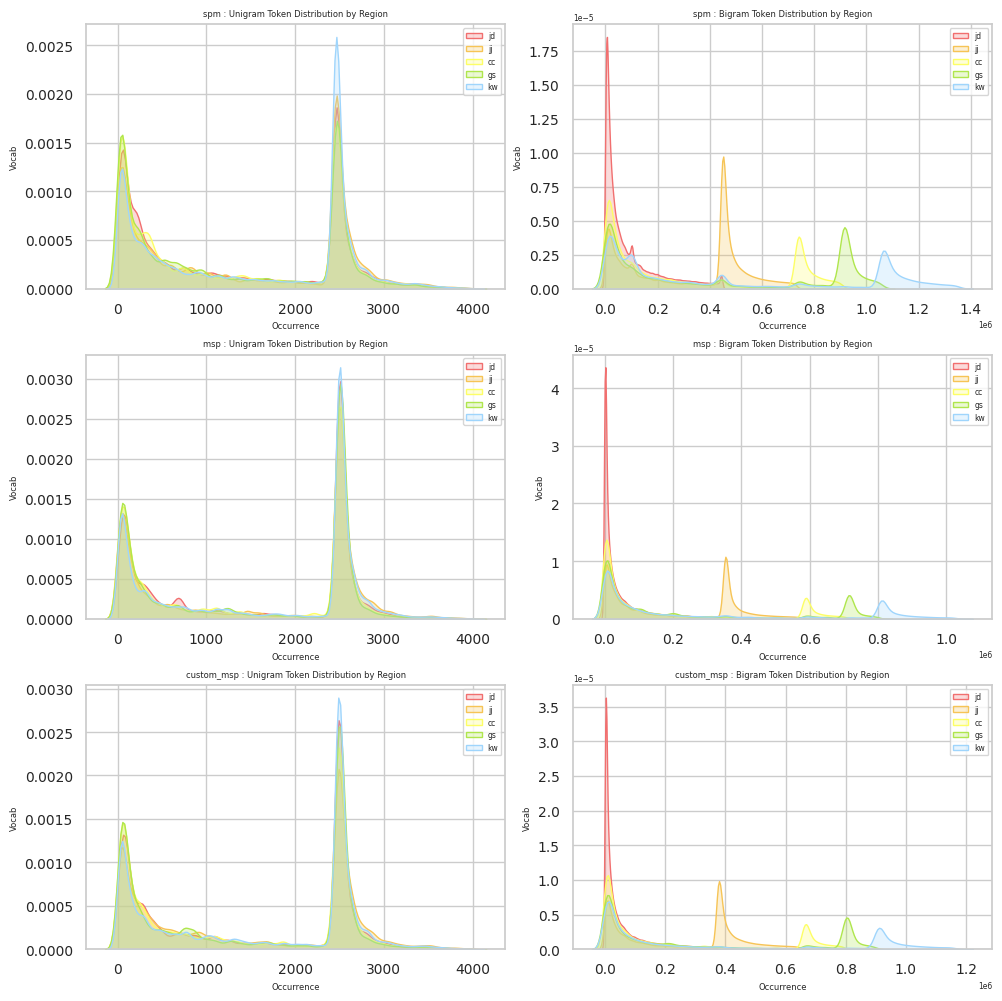

In [92]:
uni_bi_distribution_plot(tokenizers_4000, 3, 2)

100%|██████████████████████████████████████| 100/100 [00:00<00:00, 38607.36it/s]


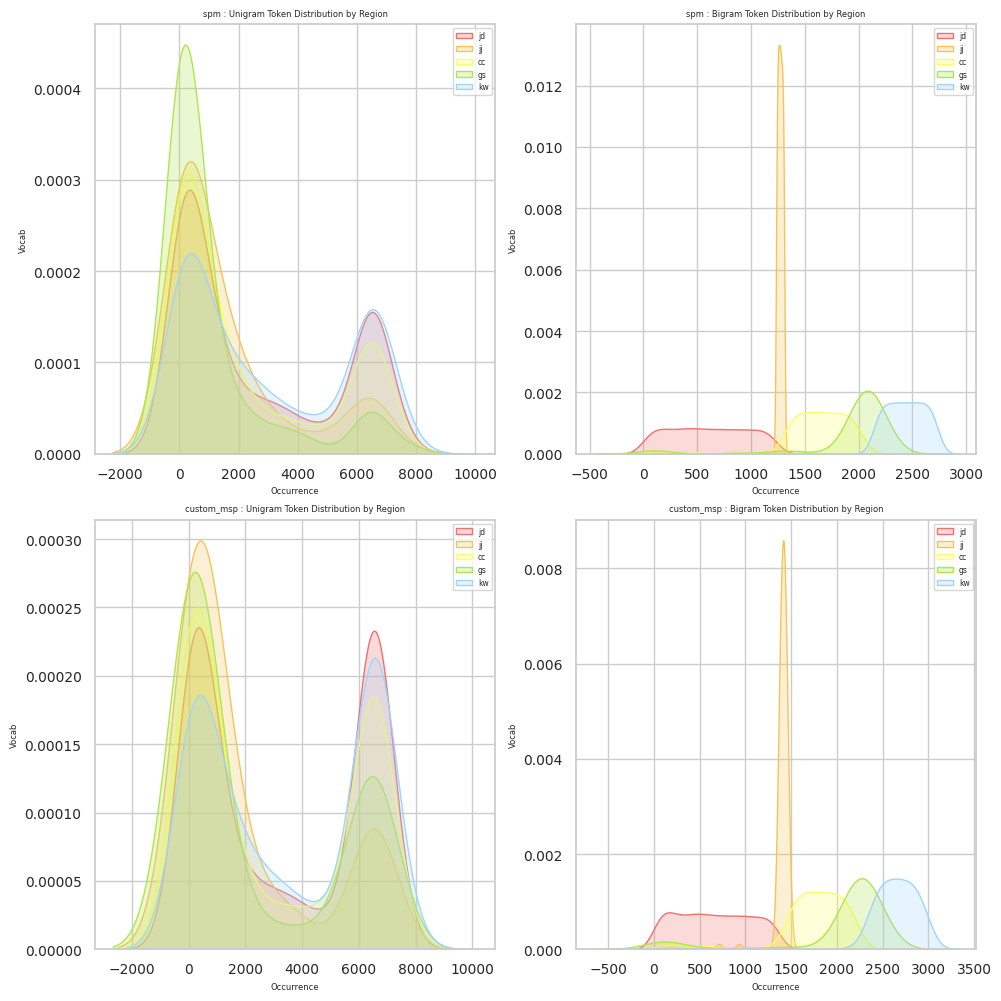

In [90]:
uni_bi_distribution_plot(tokenizers_8000, 2, 2)

100%|████████████████████████████████| 496436/496436 [00:26<00:00, 18626.25it/s]


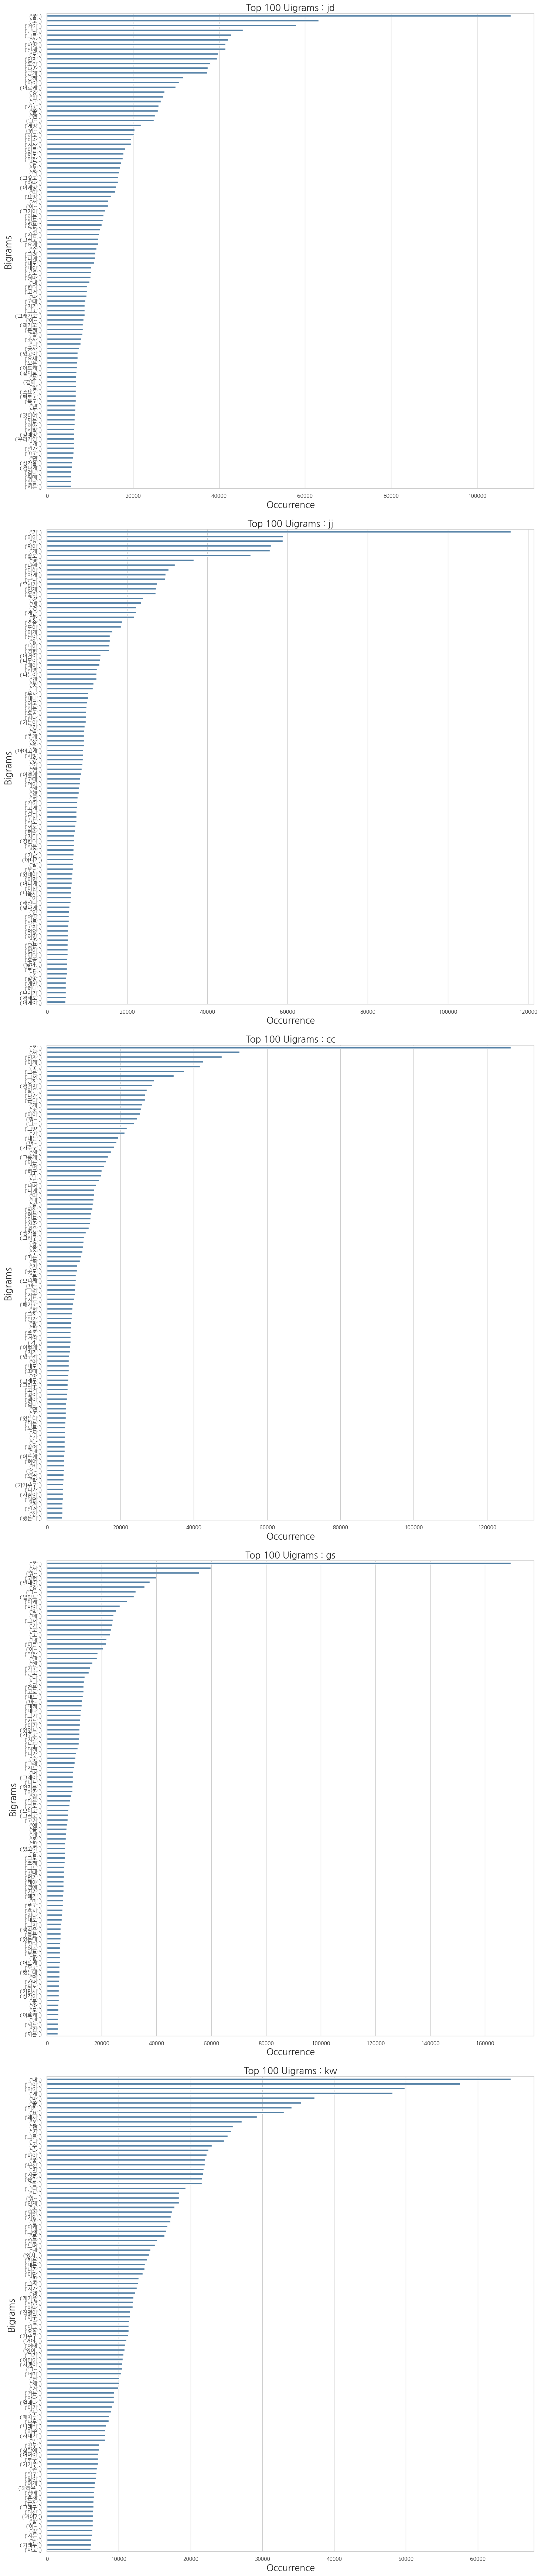

In [47]:
#by reg
from nltk import ngrams

fig = plt.figure(figsize=(15,70))
df_com = pd.DataFrame()
for i, reg in enumerate(regs) :
    
    frequency_pos = Counter()
    dial = df_train.loc[df_train['reg'] == reg,'dial'].values
    for k in tqdm.tqdm(dial) :
        tokenized = ''.join(msp_4000.encode_as_pieces(k)).replace('▁',' ').split()
        token_words = ngrams(tokenized,1)
        frequency_pos.update(token_words)

    df_pos = pd.DataFrame(frequency_pos.most_common(100))

    # Barplot that shows the top most common
    
    plt.subplot(5,1,i+1)
    sns.set(font_scale = 1.5, style = 'whitegrid', font ='NanumGothic')
    sns_pos_1 = sns.barplot(x = df_pos[1], y = df_pos[0], color = 'steelblue', width=0.4)

    # Setting axes labels
    sns_pos_1.set(xlabel = 'Occurrence', ylabel = 'Bigrams', title = f'Top 100 Uigrams : {reg}')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    
plt.tight_layout()
plt.show()

100%|███████████████████████████████████████████████████████████████| 496436/496436 [00:30<00:00, 16303.58it/s]


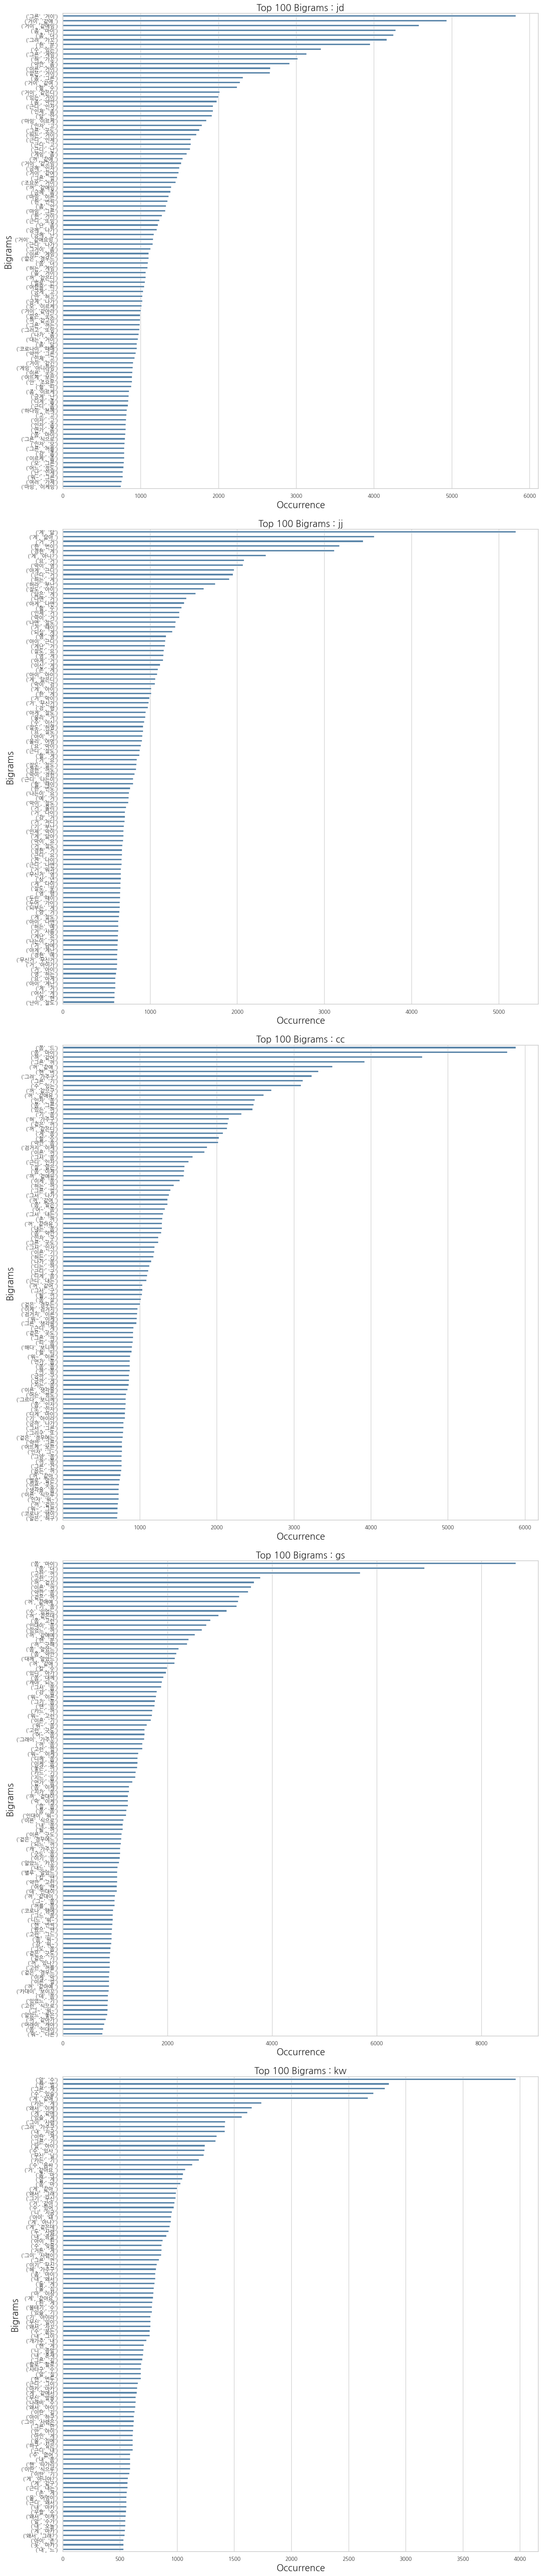

In [196]:
#by reg

fig = plt.figure(figsize=(15,70))

for i, reg in enumerate(regs) :
    
    frequency_pos = Counter()
    dial = df_train.loc[df_train['reg'] == reg,'dial'].values
    for k in tqdm.tqdm(dial) :
        tokenized = ''.join(msp_4000.encode_as_pieces(k)).replace('▁',' ').split()
        token_words = ngrams(tokenized,2)
        frequency_pos.update(token_words)

    df_pos = pd.DataFrame(frequency_pos.most_common(100))

    # Barplot that shows the top most common
    
    plt.subplot(5,1,i+1)
    sns.set(font_scale = 1.5, style = 'whitegrid', font ='NanumGothic')
    sns_pos_1 = sns.barplot(x = df_pos[1], y = df_pos[0], color = 'steelblue', width=0.4)

    # Setting axes labels
    sns_pos_1.set(xlabel = 'Occurrence', ylabel = 'Bigrams', title = f'Top 100 Bigrams : {reg}')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    
plt.tight_layout()
plt.show()

## 2. unk count
- oov 개수

### tok 4000

In [21]:
split_token = set()
dial = df_train['dial'].values
for i in tqdm.tqdm(dial) :
    split_token |= set(i.split())

100%|█████████████████████████████| 1340262/1340262 [00:06<00:00, 214056.88it/s]


In [25]:
print('split 기준 토크나이저를 사용하여 4000개 기준 vocab으로 하면 최소 oov 개수가 ', (4000 -  len(split_token))*-1,'임' )

split 기준 토크나이저를 사용하여 4000개 기준 vocab으로 하면 최소 oov 개수가  744112 임


In [16]:
tok_spm= []
tok_msp= []
tok_cmsp = []
dial = df_train['dial'].values
for i in tqdm.tqdm(dial) :
    tok_spm.extend(spm_4000.encode(i))
    tok_msp.extend(msp_4000.encode(i))
    tok_cmsp.extend(custom_msp_4000.encode(i))
    
print('spm unk cnt : ', tok_spm.count(spm_4000.unk_id()))
print('msp unk cnt : ', tok_msp.count(msp_4000.unk_id()))
print('cmsp unk cnt : ', tok_cmsp.count(custom_msp_4000.unk_id()))

100%|███████████████████████████████| 1340262/1340262 [03:35<00:00, 6232.33it/s]


spm unk cnt :  525174
msp unk cnt :  50605
cmsp unk cnt :  48850


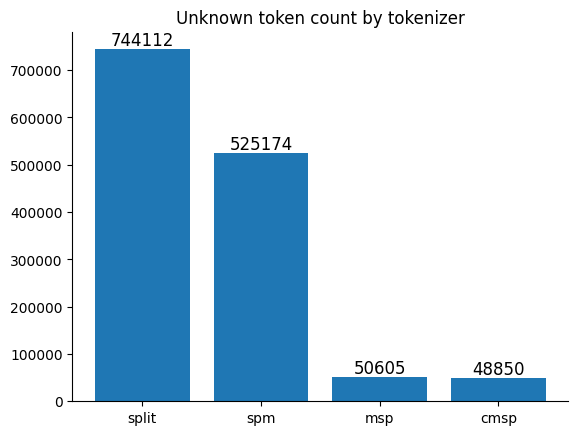

In [26]:
import seaborn as sns
fig, ax = plt.subplots()
bar = ax.bar(x=['split','spm','msp','cmsp'], height = [744112,tok_spm.count(spm_4000.unk_id()),tok_msp.count(msp_4000.unk_id()),tok_cmsp.count(custom_msp_4000.unk_id())])
ax.bar_label(bar,fontsize=12)
sns.despine()
plt.title('Unknown token count by tokenizer')
plt.yticks(fontsize=10)
plt.show()

### tok 8000

In [24]:
print('split 기준 토크나이저를 사용하여 8000개 기준 vocab으로 하면 최소 oov 개수가 ', (8000 -  len(split_token))*-1,'임' )

split 기준 토크나이저를 사용하여 8000개 기준 vocab으로 하면 최소 oov 개수가  740112 임


In [31]:
tok_spm= []
tok_msp= []
tok_cmsp = []
dial = df_train['dial'].values
for i in tqdm.tqdm(dial) :
    tok_spm.extend(spm_8000.encode(i))
    tok_msp.extend(msp_8000.encode(i))
    tok_cmsp.extend(custom_msp_8000.encode(i))
    

In [30]:
print('spm unk cnt : ', tok_spm.count(spm_8000.unk_id()))
print('msp unk cnt : ', tok_msp.count(msp_8000.unk_id()))
print('cmsp unk cnt : ', tok_cmsp.count(custom_msp_8000.unk_id()))

spm unk cnt :  40806
msp unk cnt :  50605
cmsp unk cnt :  49086


In [44]:
# unk %
print(round((tok_spm.count(spm_8000.unk_id())/len(tok_spm))* 100,2 ))
print(round((tok_msp.count(msp_8000.unk_id())/len(tok_msp)) * 100,2 ))
print(round((tok_cmsp.count(custom_msp_8000.unk_id())/len(tok_cmsp)) * 100,2))

0.1
0.11
0.11


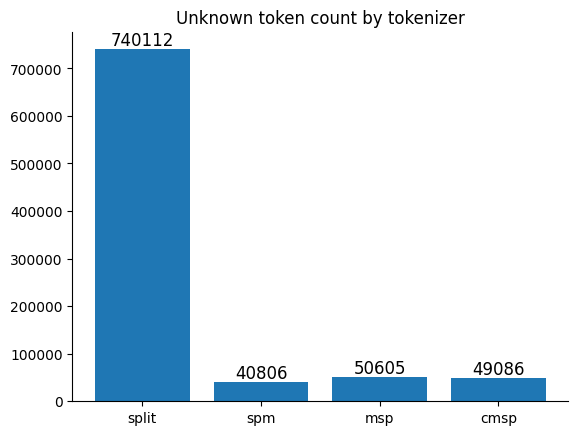

In [32]:
import seaborn as sns
fig, ax = plt.subplots()
bar = ax.bar(x=['split','spm','msp','cmsp'], height = [740112,tok_spm.count(spm_8000.unk_id()),tok_msp.count(msp_8000.unk_id()),tok_cmsp.count(custom_msp_8000.unk_id())])
ax.bar_label(bar,fontsize=12)
sns.despine()
plt.title('Unknown token count by tokenizer')
plt.yticks(fontsize=10)
plt.show()

## 3. subword fertility

- 토큰화된 단어마다 생성되는 부분단어의 평균 개수

### tok 4000

In [46]:
tok_spm= []
tok_msp= []
tok_cmsp =[]
dial = df_train['dial'].values
for i in tqdm.tqdm(dial) :
    #split by empty space
    tok_spm_len_split = len(i.split())
    
    #split by tokenzier
    tok_spm_len = len(spm_4000.encode(i))
    tok_msp_len = len(msp_4000.encode(i))
    tok_cmsp_len = len(custom_msp_4000.encode(i))
    
    # find percentage of subword split
    tok_spm.append(tok_spm_len / tok_spm_len_split )
    tok_msp.append(tok_msp_len / tok_spm_len_split)
    tok_cmsp.append(tok_cmsp_len / tok_spm_len_split)

100%|███████████████████████████████| 1340262/1340262 [03:37<00:00, 6158.82it/s]


In [48]:
print('spm subword fertility :',sum(tok_spm)/len(tok_spm))
print('msp subword fertility :',sum(tok_msp)/len(tok_msp))
print('msp subword fertility :',sum(tok_cmsp)/len(tok_cmsp))

spm subword fertility : 2.193813034295701
msp subword fertility : 2.312592527239291
msp subword fertility : 2.193100479279696


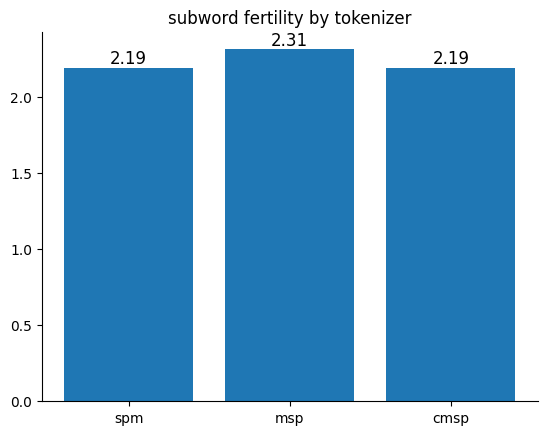

In [49]:
fig, ax = plt.subplots()
bar = ax.bar(x=['spm','msp','cmsp'], height = [round(sum(tok_spm)/len(tok_spm),2),round(sum(tok_msp)/len(tok_msp),2),round(sum(tok_cmsp)/len(tok_cmsp),2)])
ax.bar_label(bar,fontsize=12)
sns.despine()
plt.title('subword fertility by tokenizer')
plt.yticks(fontsize=10)
plt.show()

### tok 8000

In [19]:
tok_spm= []
tok_msp= []
tok_cmsp =[]
dial = df_train['dial'].values
for i in tqdm.tqdm(dial) :
    #split by empty space
    tok_spm_len_split = len(i.split())
    
    #split by tokenzier
    tok_spm_len = len(spm_8000.encode(i))
    tok_msp_len = len(msp_8000.encode(i))
    tok_cmsp_len = len(custom_msp_8000.encode(i))
    
    # find percentage of subword split
    tok_spm.append(tok_spm_len / tok_spm_len_split )
    tok_msp.append(tok_msp_len / tok_spm_len_split)
    tok_cmsp.append(tok_cmsp_len / tok_spm_len_split)
    
print('spm subword fertility :',sum(tok_spm)/len(tok_spm))
print('msp subword fertility :',sum(tok_msp)/len(tok_msp))
print('msp subword fertility :',sum(tok_cmsp)/len(tok_cmsp))

100%|███████████████████████████████| 1340262/1340262 [03:22<00:00, 6623.72it/s]

spm subword fertility : 1.7582113560464425
msp subword fertility : 2.1373078740151397
msp subword fertility : 1.961404541170287


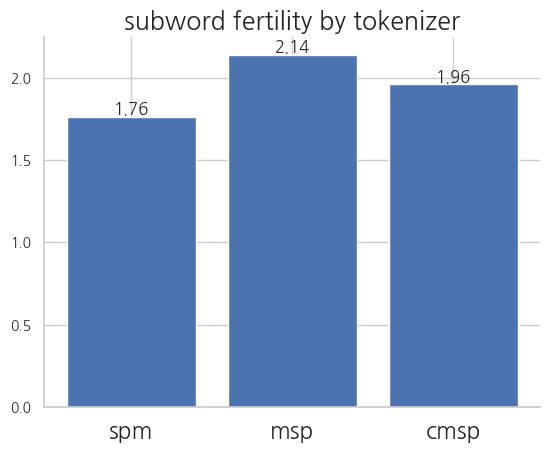

In [20]:
fig, ax = plt.subplots()
bar = ax.bar(x=['spm','msp','cmsp'], height = [round(sum(tok_spm)/len(tok_spm),2),round(sum(tok_msp)/len(tok_msp),2),round(sum(tok_cmsp)/len(tok_cmsp),2)])
ax.bar_label(bar,fontsize=12)
sns.despine()
plt.title('subword fertility by tokenizer')
plt.yticks(fontsize=10)
plt.show()

### proportion of continued words 
- 말뭉치에서 적어두 두 개의 부분 토큰으로 분활된 토큰화된 단어의 비율

### tok 4000

In [23]:
tok_spm= []
tok_msp= []
tok_cmsp= []
tok_split = []
dial = df_train['dial'].values
for i in tqdm.tqdm(dial) :
    total_cnt = 0
    spm_temp = 0
    msp_temp = 0
    cmsp_temp=0
    for k in i.split() :
        if k == ' ' or k ==  '\u200b' or k =='\x9f':
            continue
        total_cnt += 1
        word_spm = spm_4000.encode_as_pieces(k)
        word_msp = msp_4000.encode_as_pieces(k)
        word_cmsp = custom_msp_4000.encode_as_pieces(k)
        
        if word_spm[0] == '▁' :
            word_spm.remove('▁')
            
        if word_msp[0] == '▁' :
            word_msp.remove('▁')
        
        if word_cmsp[0] == '▁' :
            word_cmsp.remove('▁')
            
        if len(word_spm) > 1 : spm_temp+=1
        if len(word_msp) > 1 : msp_temp+=1
        if len(word_cmsp) > 1 : cmsp_temp+=1            
                        
    tok_spm.append(spm_temp)
    tok_msp.append(msp_temp)
    tok_cmsp.append(cmsp_temp)
    tok_split.append(total_cnt)

100%|███████████████████████████████| 1340262/1340262 [05:58<00:00, 3737.92it/s]


In [24]:
print('spm proportion of continued words :', sum(tok_spm)/sum(tok_split) * 100)
print('msp proportion of continued words :',sum(tok_msp)/sum(tok_split) * 100)
print('cmsp proportion of continued words :',sum(tok_cmsp)/sum(tok_split) * 100)

spm proportion of continued words : 55.13527722500944
msp proportion of continued words : 67.53569775943595
cmsp proportion of continued words : 62.722492988763655


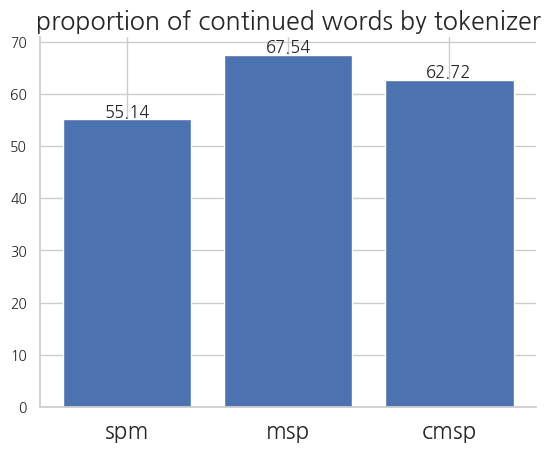

In [27]:
fig, ax = plt.subplots()
bar = ax.bar(x=['spm','msp','cmsp'], height = [round(sum(tok_spm)/sum(tok_split) * 100,2),round(sum(tok_msp)/sum(tok_split) * 100,2),round(sum(tok_cmsp)/sum(tok_split) * 100,2)])
ax.bar_label(bar,fontsize=12)
sns.despine()
plt.title('proportion of continued words by tokenizer')
plt.yticks(fontsize=10)
plt.show()

### tok 8000

In [28]:
tok_spm= []
tok_msp= []
tok_cmsp= []
tok_split = []
dial = df_train['dial'].values
for i in tqdm.tqdm(dial) :
    total_cnt = 0
    spm_temp = 0
    msp_temp = 0
    cmsp_temp=0
    for k in i.split() :
        if k == ' ' or k ==  '\u200b' or k =='\x9f':
            continue
        total_cnt += 1
        word_spm = spm_8000.encode_as_pieces(k)
        word_msp = msp_8000.encode_as_pieces(k)
        word_cmsp = custom_msp_8000.encode_as_pieces(k)
        
        if word_spm[0] == '▁' :
            word_spm.remove('▁')
            
        if word_msp[0] == '▁' :
            word_msp.remove('▁')
        
        if word_cmsp[0] == '▁' :
            word_cmsp.remove('▁')
            
        if len(word_spm) > 1 : spm_temp+=1
        if len(word_msp) > 1 : msp_temp+=1
        if len(word_cmsp) > 1 : cmsp_temp+=1            
                        
    tok_spm.append(spm_temp)
    tok_msp.append(msp_temp)
    tok_cmsp.append(cmsp_temp)
    tok_split.append(total_cnt)

100%|███████████████████████████████| 1340262/1340262 [05:51<00:00, 3809.60it/s]


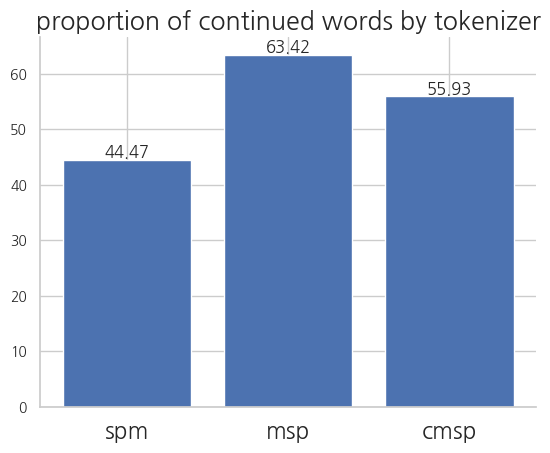

In [30]:
fig, ax = plt.subplots()
bar = ax.bar(x=['spm','msp','cmsp'], height = [round(sum(tok_spm)/sum(tok_split) * 100,2),round(sum(tok_msp)/sum(tok_split) * 100,2),round(sum(tok_cmsp)/sum(tok_split) * 100,2)])
ax.bar_label(bar,fontsize=12)
sns.despine()
plt.title('proportion of continued words by tokenizer')
plt.yticks(fontsize=10)
plt.show()